In [2]:
import pandas as pd
import numpy as np
import os
import glob
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from pyproj import Transformer
import xml.etree.ElementTree as ET
import json
import ipyparallel as ipp
import boto3
import pickle
import io
import geopandas as gpd
from shapely.geometry import Point
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

### Run from below next markdown with loading of almonds pickle file

In [2]:
def get_cdl_value(year, lon, lat):
    """
    Fetches and parses the CDL value for a given year, lon, and lat coordinates.

    Args:
        year (int): The year of the data.
        lon (float): The longitude.
        lat (float): The latitude.

    Returns:
        dict: A dictionary containing the result data.
              Returns None if the request fails or the Result element is not found.
    """
    transformer = Transformer.from_crs("epsg:4326", "epsg:5070", always_xy=True)
    x, y = transformer.transform(lon, lat)
    url = f"https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLValue?year={year}&x={x}&y={y}"
    response = requests.get(url)

    if response.status_code == 200: # success
        root = ET.fromstring(response.content)
        result_element = root.find(".//Result")

        if result_element is not None:
            result_string = result_element.text
            # weird xml format fix
            result_string = result_string.replace("{", "{\"").replace(":", "\":").replace(", ", ", \"")
            result_dict = json.loads(result_string)
            return result_dict
        else:
            print("Result element not found in the XML response.")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [3]:
central_5021 = pd.read_csv("../data/central_stations_observations.csv")
central_5021 = central_5021[central_5021.Basin_Subb.str.startswith("5-021")]

In [4]:
central_5021

,site_code,latitude,longitude,well_depth,well_use,geology,Region_Off,Basin_Subb,observations_2010,observations_2011,...,observations_2015,observations_2016,observations_2017,observations_2018,observations_2019,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024
2039,366909N1221638W001,39.69090,-122.16384,320.0,Irrigation,['Q'],NRO,5-021.52,0,0,...,4,3,3,3,3,3,3,3,3,5
3433,380926N1215871W001,38.11300,-121.58719,23.0,Observation,['Q'],NCRO,5-021.66,0,0,...,0,0,0,0,0,0,0,0,0,0
3434,380926N1215871W002,38.11300,-121.58719,102.0,Observation,['Q'],NCRO,5-021.66,0,0,...,0,0,0,0,0,0,0,0,0,0
3458,381132N1216951W001,38.11322,-121.69513,416.0,Other,['Q'],NCRO,5-021.66,0,0,...,2,2,2,2,2,1,2,0,2,2
3462,381150N1215899W001,38.81150,-121.58993,340.0,Irrigation,['Q'],NCRO,5-021.64,0,0,...,23,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5862,402341N1222533W002,40.23410,-122.25329,140.0,Industrial,['QPc'],NRO,5-021.50,0,0,...,0,0,0,0,0,0,4,9,10,4
5865,402522N1222082W001,40.25221,-122.20818,200.0,Residential,['Tvp'],NRO,5-021.53,0,0,...,0,5,3,2,3,2,2,3,3,1
5866,402653N1222348W002,40.26517,-122.25339,320.0,Residential,['QPc'],NRO,5-021.50,0,0,...,0,0,0,0,0,0,3,0,0,0
5964,410921N1210855W001,40.09211,-122.08555,680.0,Observation,['QPc'],NRO,5-021.56,0,0,...,0,0,0,0,0,0,176,244,340,371


In [5]:
s3_bucket = 'ds-h-ca-bigdata'
s3_prefix = 'ECOSTRESS/'

session = boto3.Session(profile_name='default')
s3 = session.client('s3', region_name='us-east-2')

response = s3.list_objects_v2(Bucket=s3_bucket, Prefix=s3_prefix, Delimiter='/')
year_folders = [prefix['Prefix'] for prefix in response.get('CommonPrefixes', [])]
print("Year folders found:", year_folders)

Year folders found: ['ECOSTRESS/2018/', 'ECOSTRESS/2019/', 'ECOSTRESS/2020/', 'ECOSTRESS/2021/', 'ECOSTRESS/2022/']


Next cell should take between 10 and 15 minutes depending on internet and AWS speeds.

Run below and load almonds_ECOSTRESS.pkl for all the data pre processed.

In [6]:
yearly_dfs = {}

for folder in year_folders:
    tif_response = s3.list_objects_v2(Bucket=s3_bucket, Prefix=folder, Delimiter='/')
    tif_files = [obj['Key'] for obj in tif_response.get('Contents', []) if obj['Key'].endswith('.tif')]
    df_list = []
    for tif_file in tqdm(tif_files, desc=f"Processing files in {folder}", leave=False):
        s3_path = f'/vsis3/{s3_bucket}/{tif_file}'
        with rasterio.open(s3_path) as src:
            data = src.read(1)
            transform = src.transform
        
        rows, cols = data.shape
        row_inds, col_inds = np.indices((rows, cols))
        xs, ys = rasterio.transform.xy(transform, row_inds, col_inds)
        xs = np.array(xs)
        ys = np.array(ys)
        
        df = pd.DataFrame({
            'x': xs.flatten(),
            'y': ys.flatten(),
            'value': data.flatten()
        })
        df_list.append(df)
    
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        parts = folder.split('/')
        if len(parts) >= 2:
            year = parts[1]
        else:
            year = folder
        yearly_dfs[year] = combined_df

Can now skip to loading almonds.csv already done these cells below.

In [13]:
obs_cols = [col for col in central_5021 if col.split("_")[0] == "observations"]
obs_cols = [col for col in obs_cols if int(col.split("_")[1]) >= 2018]

In [14]:
central_5021 = central_5021[central_5021[obs_cols].ge(25).all(axis=1)]

In [24]:
def parallel_fetch(args):
    """
    Helper that receives a tuple (index, row).  
    For each year from 2018 to 2024, it calls `get_cdl_value`.
    Returns (index, {year: <the CDL dictionary or None>}).
    """
    idx, row = args
    lon = row['longitude']
    lat = row['latitude']
    
    results = {}
    for year in range(2018, 2025):
        cdl_dict = get_cdl_value(year, lon, lat)
        results[year] = cdl_dict
    return idx, results

rc = ipp.Client()
lview = rc.load_balanced_view()
rc[:].push({"get_cdl_value":get_cdl_value})
rc[:].execute("""
import requests
from pyproj import Transformer
import xml.etree.ElementTree as ET
import json
""")
rows_to_process = [(idx, row) for idx, row in central_5021.iterrows()]
async_result = lview.map_async(parallel_fetch, rows_to_process)
results_list = async_result.get()

for idx, year_dict in results_list:
    for year, cdl in year_dict.items():
        col_name = f"CDL_{year}"
        if cdl is not None:
            central_5021.loc[idx, col_name] = str(cdl.get("category"))
        else:
            central_5021.loc[idx, col_name] = None

In [25]:
central_5021.head()

,site_code,latitude,longitude,well_depth,well_use,geology,Region_Off,Basin_Subb,observations_2010,observations_2011,...,observations_2022,observations_2023,observations_2024,CDL_2018,CDL_2019,CDL_2020,CDL_2021,CDL_2022,CDL_2023,CDL_2024
3750,384159N1217303W001,38.41590,-121.73030,43.0,Observation,['Q'],NCRO,5-021.66,391,384,...,384,378,257,Developed/Open Space,Broccoli,Almonds,Almonds,Almonds,Prunes,Grapes
3751,384159N1217303W002,38.41585,-121.73034,243.0,Observation,['Q'],NCRO,5-021.66,306,358,...,384,269,197,Developed/Open Space,Broccoli,Almonds,Almonds,Almonds,Prunes,Grapes
3752,384159N1217303W003,38.41590,-121.73030,445.0,Observation,['Q'],NCRO,5-021.66,364,384,...,384,378,197,Developed/Open Space,Broccoli,Almonds,Almonds,Almonds,Prunes,Grapes
4119,386464N1216675W002,38.64640,-121.66750,150.0,Observation,['Q'],NCRO,5-021.67,374,377,...,302,280,341,Walnuts,Fallow/Idle Cropland,Sunflowers,Winter Wheat,Safflower,Winter Wheat,Developed/Low Intensity
4120,386464N1216675W003,38.64640,-121.66750,280.0,Observation,['Q'],NCRO,5-021.67,374,377,...,163,262,341,Walnuts,Fallow/Idle Cropland,Sunflowers,Winter Wheat,Safflower,Winter Wheat,Developed/Low Intensity


In [26]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

def interpolate_gwe(site_code, years, readings_df):
    site_data = readings_df
    site_data.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    site_data['ds'] = pd.to_datetime(site_data['ds'])

    full_date_range = pd.date_range(start=f"{min(years)}-01-01", end=f"{max(years)}-12-31", freq="D")
    full_df = pd.DataFrame({'ds': full_date_range})
    full_df = full_df.merge(site_data, on='ds', how='left')

    m = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    m.fit(site_data.dropna())

    forecast = m.predict(full_df)

    full_df['y_interpolated'] = forecast['yhat']

    result_df = full_df[['ds', 'y_interpolated']].copy()
    result_df.rename(columns={"ds": "date", "y_interpolated": "gwe_interpolated"}, inplace=True)

    return result_df

def gwe_trend(site_code, start_yr, end_yr):
    years = range(start_yr, end_yr + 1)
    readings_df = get_readings_for_site(site_code, years)
    predicted = interpolate_gwe(site_code, years, readings_df)

    predicted['date'] = pd.to_datetime(predicted['date'])
    predicted.set_index('date', inplace=True)

    monthly_avg = predicted.resample('ME').mean()
    
    return monthly_avg

In [29]:
client = ipp.Client()
dview = client[:]
dview.push({'fetch_all_records': fetch_all_records,
           'get_readings_for_site':get_readings_for_site,
           'interpolate_gwe':interpolate_gwe,
           'gwe_trend':gwe_trend})

dview.execute("""
import pandas as pd
import requests
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
""")

view = client.load_balanced_view()

well_gwe_trends = {}

def process_well(well):
    return well, gwe_trend(well, 2018, 2025)

async_results = []
for well in central_5021.site_code.unique():
    async_result = view.apply_async(process_well, well)
    async_results.append(async_result)

for async_result in async_results:
    try:
        well, result = async_result.get()
        well_gwe_trends[well] = result
    except Exception as e:
        print(f"Error processing well {well}: {e}")

In [32]:
def calculate_groundwater_changes(data_dict):
    result_dict = {}
    for year in range(2018, 2025):
        year_dict = {}

        for site_code, df in data_dict.items():
            try:
                october_value = df.loc[f'{year}-10-31'].iloc[0]
                september_value = df.loc[f'{year+1}-09-30'].iloc[0]
                change = october_value - september_value
                year_dict[site_code] = change
            except KeyError:
                print(f"Warning: Missing data for site {site_code} in year {year} or {year+1}.")
                year_dict[site_code] = None

        result_dict[year] = year_dict

    return result_dict

In [33]:
well_changes = calculate_groundwater_changes(well_gwe_trends)

In [35]:
for year, site_map in well_changes.items():
    col_name = f"GWE_{year}"
    central_5021[col_name] = central_5021['site_code'].map(site_map)

In [37]:
cdl_cols = [col for col in central_5021.columns if col.split("_")[0] == "CDL"]

In [39]:
mask = (
    central_5021[cdl_cols]
    .apply(lambda row: row.astype(str).str.contains('almonds', case=False, na=False))
    .any(axis=1)
)

In [52]:
central_5021 = central_5021[mask].copy()

/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_56671/1798174882.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  central_5021 = central_5021[mask].copy()


In [46]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

def process_precipitation_data(precip_data):
    df = pd.DataFrame.from_dict(precip_data, orient="index", columns=["precipitation"])
    df.index = pd.to_datetime(df.index)
    monthly_avg = df.resample("ME").mean()
    
    return monthly_avg

def get_monthly_precipitation_for_sites(df, start_date=2008, end_date=2024):
    result_dict = {}

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing sites"):
        site_code = row["site_code"]
        latitude = row["latitude"]
        longitude = row["longitude"]

        try:
            precip_data = get_precipitation_data(latitude, longitude, start_date, end_date)
            monthly_avg = process_precipitation_data(precip_data)
            result_dict[site_code] = monthly_avg

        except Exception as e:
            print(f"Error processing site {site_code}: {e}")
            result_dict[site_code] = None

    return result_dict

In [47]:
precipitation_data = get_monthly_precipitation_for_sites(central_5021)

Processing sites: 100%|█████████████████████████| 47/47 [02:32<00:00,  3.24s/it]


In [48]:
def calculate_annual_precipitation_averages(precipitation_dict):
    result_dict = {}
    for year in range(2018, 2025):
        year_dict = {}
        for site_code, monthly_avg in precipitation_dict.items():
            if monthly_avg is not None:
                try:
                    start_date = f"{year}-10-31"
                    end_date = f"{year+1}-09-30"
                    period_data = monthly_avg.loc[start_date:end_date]
                    average_precip = period_data["precipitation"].mean()
                    year_dict[site_code] = average_precip
                except KeyError:
                    print(f"Warning: Missing data for site {site_code} in year {year}.")
                    year_dict[site_code] = None
        result_dict[year] = year_dict
    return result_dict

In [49]:
well_precipitation = calculate_annual_precipitation_averages(precipitation_data)

In [51]:
for year, site_precip_map in well_precipitation.items():
    col_name = f"precip_{year}"
    central_5021[col_name] = central_5021['site_code'].map(site_precip_map)

/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_56671/3762711494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_5021[col_name] = central_5021['site_code'].map(site_precip_map)
/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_56671/3762711494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_5021[col_name] = central_5021['site_code'].map(site_precip_map)
/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_56671/3762711494.py:3: SettingWithCopyWarning: 
A val

In [7]:
central_5021 = pd.read_csv("../data/almonds.csv")

In [ ]:
central_gdf = gpd.GeoDataFrame(
    central_5021,
    geometry=gpd.points_from_xy(central_5021.longitude, central_5021.latitude),
    crs="EPSG:4326"
)

central_gdf = central_gdf.to_crs("EPSG:3857")

central_gdf['buffer'] = central_gdf.geometry.buffer(1000)
buffers_gdf = central_gdf.copy()
buffers_gdf = buffers_gdf.set_geometry('buffer')

for year, df in tqdm(yearly_dfs.items()):
    year_gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.x, df.y),
        crs="EPSG:4326"
    )
    
    year_gdf = year_gdf.to_crs("EPSG:3857")
    joined = gpd.sjoin(year_gdf, buffers_gdf[['buffer']], how='inner', predicate='within')
    avg_values = joined.groupby('index_right')['value'].mean()
    col_name = f'avg_value_{year}'
    central_gdf[col_name] = avg_values

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
yearly_dfs.get("2020").head().iloc[1].value

-9999999827968.0

In [9]:
stress_2020 = yearly_dfs.get("2020")

In [16]:
filtered = stress_2020[(stress_2020.value != -9999999827968.0) & (~stress_2020.value.isna())]

In [20]:
readings_df = {}

for year, df in tqdm(yearly_dfs.items()):
    readings_df[year] = df[(df.value != -9999999827968.0) & (~df.value.isna())]

100%|██████████| 5/5 [00:28<00:00,  5.65s/it]


In [28]:
def create_point(x, y):
    return Point((x, y))

points_dict = {}

for key, df in readings_df.items():
    points = Parallel(n_jobs=-1)(
        delayed(create_point)(x, y)
        for x, y in tqdm(zip(df['x'], df['y']), total=len(df), desc=f"Processing {key}")
    )
    points_dict[key] = points

Processing 2022: 100%|██████████| 16158242/16158242 [01:27<00:00, 184789.92it/s]


In [31]:
ecostress_gdf = {}

for year, df in tqdm(readings_df.items()):
    ecostress_gdf[year] = gpd.GeoDataFrame(df, geometry=points_dict.get(year), crs="EPSG:4326")

100%|██████████| 5/5 [15:30<00:00, 186.05s/it]


In [32]:
ecostress_gdf.get("2018")

,x,y,value,geometry
256142,-121.402900,39.252489,117.581200,POINT (-121.4029 39.25249)
258813,-121.403531,39.251858,117.293106,POINT (-121.40353 39.25186)
258814,-121.402900,39.251858,117.293106,POINT (-121.4029 39.25186)
258815,-121.402269,39.251858,116.734184,POINT (-121.40227 39.25186)
261483,-121.404793,39.251227,116.602760,POINT (-121.40479 39.25123)
...,...,...,...,...
554421752,-122.091566,38.598296,46.363491,POINT (-122.09157 38.5983)
554424408,-122.102292,38.597665,53.336006,POINT (-122.10229 38.59766)
554424409,-122.101661,38.597665,51.686615,POINT (-122.10166 38.59766)
554424410,-122.101030,38.597665,52.338512,POINT (-122.10103 38.59766)


In [2]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
gdf = gdf[gdf['Basin_Numb'] == '5-021']

In [41]:
gdf = gdf.to_crs(ecostress_gdf.get("2018").crs)

In [51]:
central_gdf = gpd.GeoDataFrame(
    central_5021,
    geometry=gpd.points_from_xy(central_5021.longitude, central_5021.latitude),
    crs="EPSG:4326"
)
central_gdf = central_gdf.to_crs("EPSG:3857")

central_gdf['buffer'] = central_gdf.geometry.buffer(1000)
buffers_gdf = central_gdf.copy()
buffers_gdf = buffers_gdf.set_geometry('buffer')

In [50]:
points_gdf = ecostress_gdf.get("2018")

In [56]:
buffers_gdf = buffers_gdf.to_crs(points_gdf.crs)

In [ ]:
for year, points_gdf in tqdm(ecostress_gdf.items()):
    joined = gpd.sjoin(points_gdf, buffers_gdf, how="inner", predicate="within")
    mean_values = joined.groupby("index_right")["value"].mean()
    col_name = f"evapo_{year}"
    buffers_gdf.loc[mean_values.index, col_name] = mean_values


 20%|██        | 1/5 [00:01<00:05,  1.29s/it]

### Run from here

In [3]:
with open('../data/almonds_ECOSTRESS.pkl', 'rb') as file:
    buffers_gdf = pickle.load(file)

In [4]:
ecostress_2 = buffers_gdf[["site_code", "latitude", "well_use", 'GWE_2018',
       'GWE_2019', 'GWE_2020', 'GWE_2021', 'GWE_2022', 'GWE_2023', 'GWE_2024',
       'precip_2018', 'precip_2019', 'precip_2020', 'precip_2021',
       'precip_2022', 'precip_2023', 'precip_2024', 'geometry', 'buffer',
       'evapo_2018', 'evapo_2019', 'evapo_2020', 'evapo_2021', 'evapo_2022']].copy()

In [5]:
for year in range(2018, 2023):
    ecostress_2["Et-P_" + str(year)] = ecostress_2["evapo_" + str(year)] - ecostress_2["precip_" + str(year)]

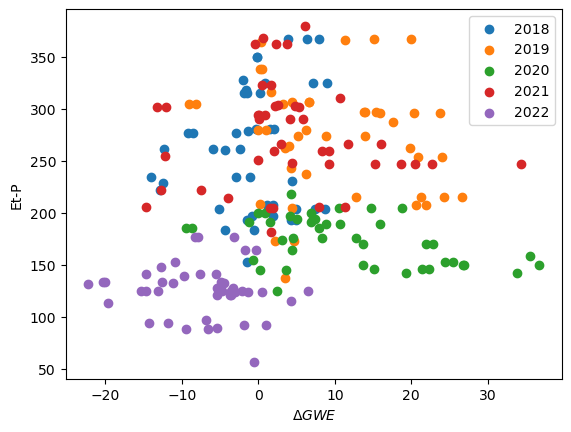

In [6]:
plt.scatter(y=ecostress_2["Et-P_2018"], x=ecostress_2["GWE_2018"], label="2018")
plt.scatter(y=ecostress_2["Et-P_2019"], x=ecostress_2["GWE_2019"], label="2019")
plt.scatter(y=ecostress_2["Et-P_2020"], x=ecostress_2["GWE_2020"], label="2020")
plt.scatter(y=ecostress_2["Et-P_2021"], x=ecostress_2["GWE_2021"], label="2021")
plt.scatter(y=ecostress_2["Et-P_2022"], x=ecostress_2["GWE_2022"], label="2022")
plt.xlabel("$\Delta GWE$")
plt.ylabel("Et-P")
plt.legend()
plt.show()

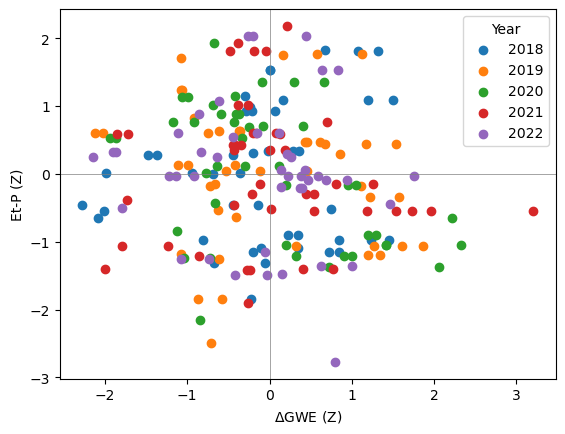

In [7]:
years = [2018, 2019, 2020, 2021, 2022]

for year in years:
    x = ecostress_2[f"GWE_{year}"]
    y = ecostress_2[f"Et-P_{year}"]

    x_z = (x - x.mean()) / x.std(ddof=0)
    y_z = (y - y.mean()) / y.std(ddof=0)

    plt.scatter(x_z, y_z, label=str(year))

plt.xlabel(r"$\Delta\mathrm{GWE}$ (Z)")
plt.ylabel("Et-P (Z)")
plt.legend(title="Year")
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

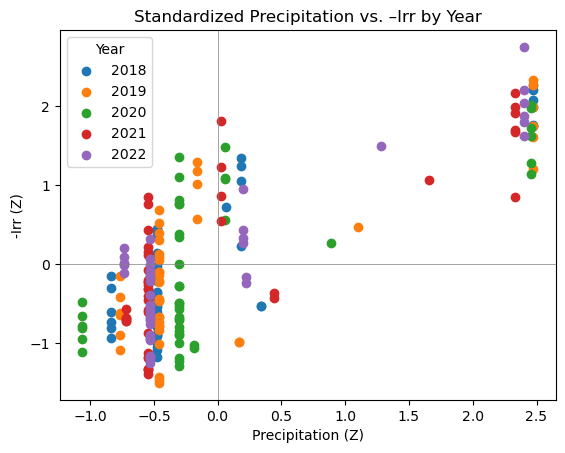

In [8]:
years = range(2018, 2023)

for yr in years:
    p = ecostress_2[f'precip_{yr}']
    e = ecostress_2[f'evapo_{yr}']
    g = ecostress_2[f'GWE_{yr}']
    p_z = (p - p.mean()) / p.std(ddof=0)
    e_z = (e - e.mean()) / e.std(ddof=0)
    g_z = (g - g.mean()) / g.std(ddof=0)
    irr_raw = p_z - e_z + g_z
    irr_z = (irr_raw - irr_raw.mean()) / irr_raw.std(ddof=0)

    plt.scatter(p_z, irr_z, label=str(yr))

plt.xlabel("Precipitation (Z)")
plt.ylabel("-Irr (Z)")
plt.title("Standardized Precipitation vs. –Irr by Year")
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.legend(title="Year")
plt.show()

Using 220 points; dropped 15 invalid entries.
Fit: y = 0.772 x + 0.006  (R² = 0.631)


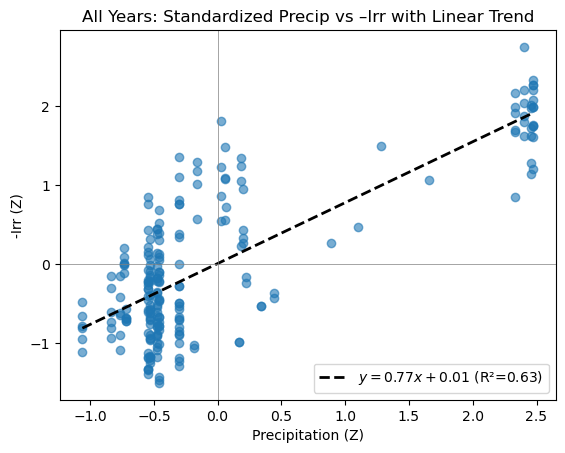

In [9]:
years = range(2018, 2023)

precip_z_all = []
irr_z_all    = []

for yr in years:
    p = ecostress_2[f'precip_{yr}']
    e = ecostress_2[f'evapo_{yr}']
    g = ecostress_2[f'GWE_{yr}']
    p_z = (p - p.mean()) / p.std(ddof=0)
    e_z = (e - e.mean()) / e.std(ddof=0)
    g_z = (g - g.mean()) / g.std(ddof=0)

    irr_raw = p_z - e_z + g_z
    irr_z   = (irr_raw - irr_raw.mean()) / irr_raw.std(ddof=0)

    precip_z_all.append(p_z.values)
    irr_z_all.append(irr_z.values)

x = np.concatenate(precip_z_all)
y = np.concatenate(irr_z_all)

mask = np.isfinite(x) & np.isfinite(y)
x_clean = x[mask]
y_clean = y[mask]

print(f"Using {len(x_clean)} points; dropped {len(x)-len(x_clean)} invalid entries.")

if np.isclose(x_clean.std(), 0) or np.isclose(y_clean.std(), 0):
    raise ValueError("One of the variables has (almost) zero variance; cannot fit a line.")

m, b = np.polyfit(x_clean, y_clean, 1)
r  = np.corrcoef(x_clean, y_clean)[0,1]
r2 = r**2
print(f"Fit: y = {m:.3f} x + {b:.3f}  (R² = {r2:.3f})")

plt.scatter(x_clean, y_clean, alpha=0.6)
xx = np.linspace(x_clean.min(), x_clean.max(), 200)
plt.plot(xx, m*xx + b, 'k--', linewidth=2,
         label=f"$y={m:.2f}x+{b:.2f}$ (R²={r2:.2f})")

plt.xlabel("Precipitation (Z)")
plt.ylabel("-Irr (Z)")
plt.title("All Years: Standardized Precip vs –Irr with Linear Trend")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.show()

In [10]:
cols_gwe = ['GWE_2018', 'GWE_2019', 'GWE_2020', 'GWE_2021', 'GWE_2022', 'GWE_2023', 'GWE_2024']
ecostress_2[cols_gwe] = (ecostress_2[cols_gwe] - ecostress_2[cols_gwe].mean()) / ecostress_2[cols_gwe].std()

cols_precip = ['precip_2018', 'precip_2019', 'precip_2020', 'precip_2021', 'precip_2022', 'precip_2023', 'precip_2024']
ecostress_2[cols_precip] = (ecostress_2[cols_precip] - ecostress_2[cols_precip].mean()) / ecostress_2[cols_precip].std()

cols_evapo = ['evapo_2018', 'evapo_2019', 'evapo_2020', 'evapo_2021', 'evapo_2022']
ecostress_2[cols_evapo] = (ecostress_2[cols_evapo] - ecostress_2[cols_evapo].mean()) / ecostress_2[cols_evapo].std()

In [11]:
for year in range(2018, 2023):
    ecostress_2[f'-Irr(Z)_{year}'] = (ecostress_2[f'precip_{year}'] - ecostress_2[f'evapo_{year}']
                                   + ecostress_2[f'GWE_{year}'])

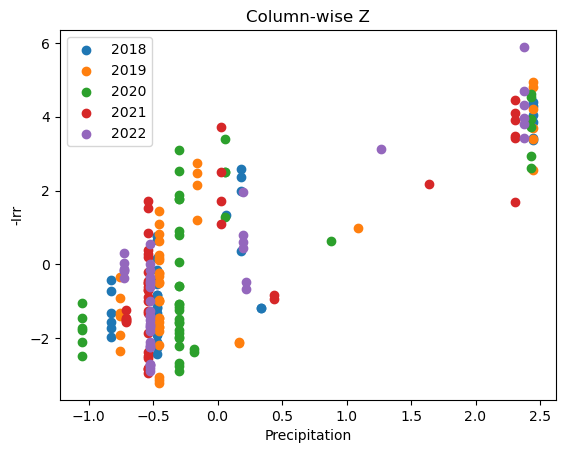

In [12]:
plt.scatter(x=ecostress_2["precip_2018"], y=ecostress_2["-Irr(Z)_2018"], label="2018")
plt.scatter(x=ecostress_2["precip_2019"], y=ecostress_2["-Irr(Z)_2019"], label="2019")
plt.scatter(x=ecostress_2["precip_2020"], y=ecostress_2["-Irr(Z)_2020"], label="2020")
plt.scatter(x=ecostress_2["precip_2021"], y=ecostress_2["-Irr(Z)_2021"], label="2021")
plt.scatter(x=ecostress_2["precip_2022"], y=ecostress_2["-Irr(Z)_2022"], label="2022")
plt.xlabel("Precipitation")
plt.ylabel("-Irr")
plt.title("Column-wise Z")
plt.legend()
plt.show()

In [13]:
ecostress_2 = ecostress_2.dropna()
precip_Z = np.concatenate([
    ecostress_2["precip_2018"],
    ecostress_2["precip_2019"],
    ecostress_2["precip_2020"],
    ecostress_2["precip_2021"],
    ecostress_2["precip_2022"]
])

irr_Z = np.concatenate([
    ecostress_2["-Irr(Z)_2018"],
    ecostress_2["-Irr(Z)_2019"],
    ecostress_2["-Irr(Z)_2020"],
    ecostress_2["-Irr(Z)_2021"],
    ecostress_2["-Irr(Z)_2022"]
])

evapo_Z = np.concatenate([
    ecostress_2["evapo_2018"],
    ecostress_2["evapo_2019"],
    ecostress_2["evapo_2020"],
    ecostress_2["evapo_2021"],
    ecostress_2["evapo_2022"]
])

GWE_Z = np.concatenate([
    ecostress_2["GWE_2018"],
    ecostress_2["GWE_2019"],
    ecostress_2["GWE_2020"],
    ecostress_2["GWE_2021"],
    ecostress_2["GWE_2022"]
])

In [14]:
precip_irr = linregress(precip_Z, irr_Z)
precip_irr.rvalue ** 2, precip_irr.pvalue

(0.6282064141885122, 9.88344354783843e-49)

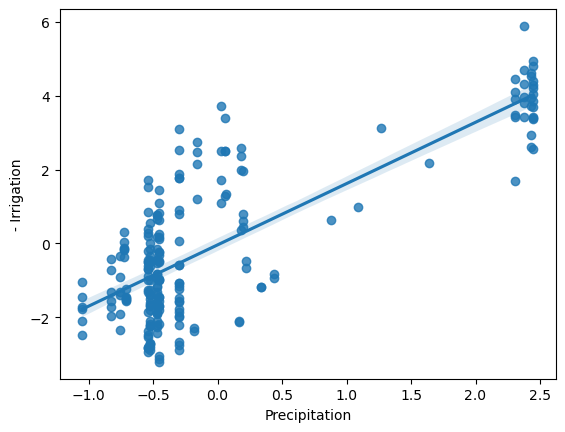

In [15]:
sns.regplot(x=precip_Z, y=irr_Z)
plt.xlabel("Precipitation")
plt.ylabel("- Irrigation")
plt.show()

In [16]:
evapo_irr = linregress(evapo_Z, irr_Z)
evapo_irr.rvalue ** 2, evapo_irr.pvalue

(0.6538965457346736, 3.952458473351625e-52)

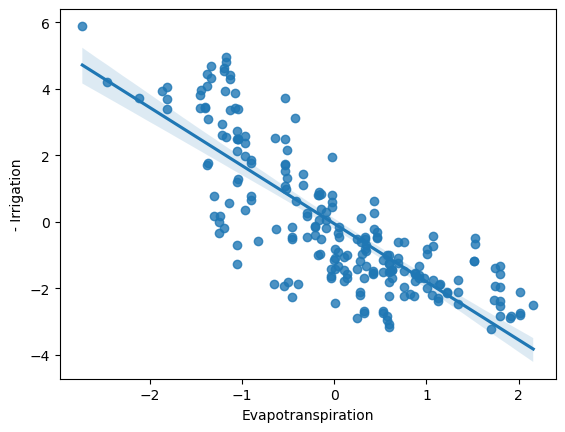

In [17]:
sns.regplot(x=evapo_Z, y=irr_Z)
plt.xlabel("Evapotranspiration")
plt.ylabel("- Irrigation")
plt.show()

In [18]:
GWE_irr = linregress(GWE_Z, irr_Z)
GWE_irr.rvalue ** 2, GWE_irr.pvalue

(0.2967924278629973, 2.106368381809862e-18)

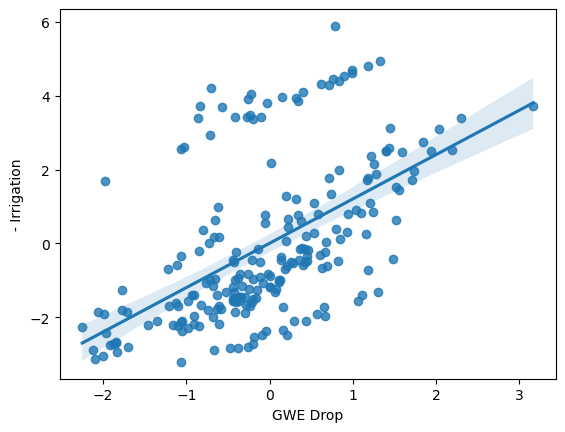

In [19]:
sns.regplot(x=GWE_Z, y=irr_Z)
plt.xlabel("GWE Drop")
plt.ylabel("- Irrigation")
plt.show()

In [20]:
for year in range(2018, 2023):
    ecostress_2["Et-P_" + str(year)] = ecostress_2["evapo_" + str(year)] - ecostress_2["precip_" + str(year)]
    ecostress_2["Et-P_" + str(year)] = (ecostress_2["Et-P_" + str(year)] - ecostress_2["Et-P_" + str(year)].mean()) / ecostress_2["Et-P_" + str(year)].std()

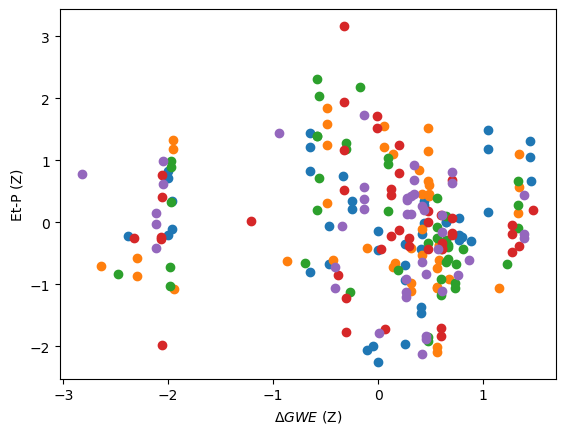

In [21]:
plt.scatter(x=ecostress_2["Et-P_2018"], y=ecostress_2["GWE_2018"], label="2018")
plt.scatter(x=ecostress_2["Et-P_2019"], y=ecostress_2["GWE_2019"], label="2019")
plt.scatter(x=ecostress_2["Et-P_2020"], y=ecostress_2["GWE_2020"], label="2020")
plt.scatter(x=ecostress_2["Et-P_2021"], y=ecostress_2["GWE_2021"], label="2021")
plt.scatter(x=ecostress_2["Et-P_2022"], y=ecostress_2["GWE_2022"], label="2022")
plt.xlabel("$\Delta GWE$ (Z)")
plt.ylabel("Et-P (Z)")
plt.show()

In [22]:
ecostress_depth = pd.merge(ecostress_2, buffers_gdf[["site_code", "well_depth"]], on="site_code")

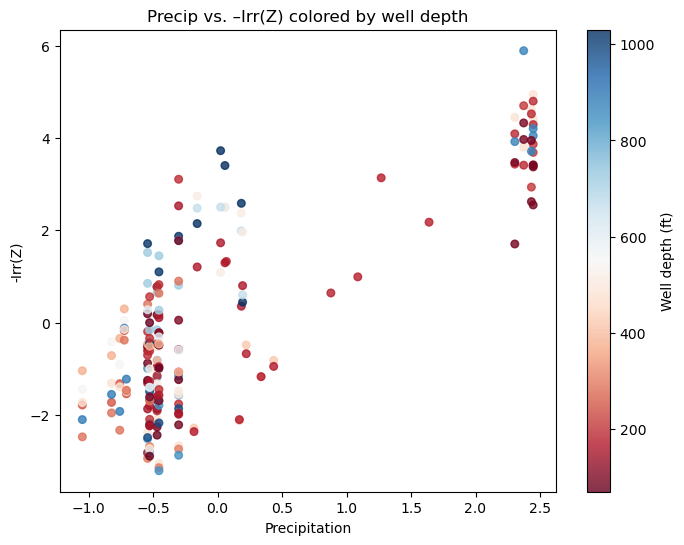

In [23]:
years = [2018, 2019, 2020, 2021, 2022]

# build X, Y and C arrays by concatenating each year’s data
x_all = np.concatenate([ecostress_depth[f"precip_{y}"].values for y in years])
y_all = np.concatenate([ecostress_depth[f"-Irr(Z)_{y}"].values for y in years])
c_all = np.concatenate([ecostress_depth["well_depth"].values   for _ in years])

# now plot them all at once, coloring by depth
plt.figure(figsize=(8,6))
sc = plt.scatter(x_all, y_all,
                 c=c_all,
                 cmap="RdBu",
                 s=30,      # marker size
                 alpha=0.8) # optional transparency

plt.colorbar(sc, label="Well depth (ft)")
plt.xlabel("Precipitation")
plt.ylabel("-Irr(Z)")
plt.title("Precip vs. –Irr(Z) colored by well depth")
plt.show()

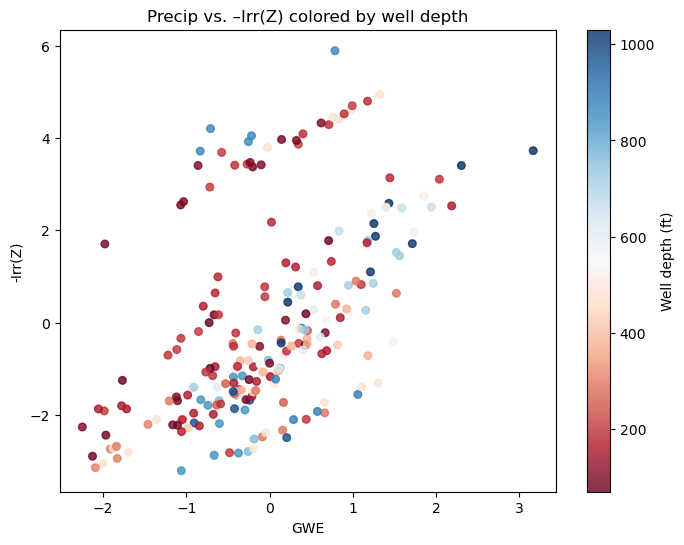

In [25]:
years = [2018, 2019, 2020, 2021, 2022]

# build X, Y and C arrays by concatenating each year’s data
x_all = np.concatenate([ecostress_depth[f"GWE_{y}"].values for y in years])
y_all = np.concatenate([ecostress_depth[f"-Irr(Z)_{y}"].values for y in years])
c_all = np.concatenate([ecostress_depth["well_depth"].values   for _ in years])

# now plot them all at once, coloring by depth
plt.figure(figsize=(8,6))
sc = plt.scatter(x_all, y_all,
                 c=c_all,
                 cmap="RdBu",
                 s=30,      # marker size
                 alpha=0.8) # optional transparency

plt.colorbar(sc, label="Well depth (ft)")
plt.xlabel("GWE")
plt.ylabel("-Irr(Z)")
plt.title("Precip vs. –Irr(Z) colored by well depth")
plt.show()